In [1]:
using Distributions, Plots, StatsPlots, LinearAlgebra, Random
using ForwardDiff: gradient
using LaTeXStrings
theme(:juno)

We are trying to sample from $\mathbf{x} \sim \mathcal{N}(\mathbf{0},\Sigma)$ where 
$$\Sigma = \begin{bmatrix}
1 & 2 \\
2 & 5
\end{bmatrix}$$
with the constraint $|\mathbf{x}| < 1$

In [2]:
μ = [0,0]
Σ = [1 2;2 5]
C(x) = 1 - (x[1]^2+x[2]^2)
function logϕ(x;μ=μ,Σ=Σ)
    if C(x) > 0
        return logpdf(MultivariateNormal(μ,Σ),x)
    else
        return -Inf
    end
end
grad(x) = gradient(x->logpdf(MultivariateNormal(μ,Σ),x),x)

grad (generic function with 1 method)

In [3]:
function DirectionRefresh(u0,refresh_rate)
    ind = rand(Bernoulli(refresh_rate))
    if ind == 0
        return u0
    else
        return normalize(rand(Normal(0,1),2))
    end
end

function reflect(u,v)
    v = normalize(v)
    return u - 2 * (transpose(u)*v)*v
end

α_pu(x,u,δ) = min(0,logϕ(x.+δ*u)-logϕ(x))

α_pu (generic function with 1 method)

In [4]:
function BPS(N,x0,u0,δ,refresh_rate)
    output = zeros(N,2)
    output[1,:] = x0
    for n = 2:N
        # Position update
        x1 = output[n-1,:] .+ δ*u0
        u1 = u0
        # Check if the proposal lies in the boundary
        if C(x1) <= 0
            # We are stepping outside the boundary, hence perform reflection
            u2 = reflect(u1,gradient(C,x1))
            x2 = x1 .+ δ*u2
            # accept the proposal with probablity min(1,π(x2)/π(x0))
            α_dr = min(0,logϕ(x2)-logϕ(output[n-1,:]))
            if log(rand(Uniform(0,1))) < α_dr
                xhat=x2
                uhat=u2
            else
                xhat=output[n-1,:]
                uhat=-u0
            end
        else
            α = α_pu(output[n-1,:],u0,δ)
            if log(rand(Uniform(0,1))) < α
                xhat = x1
                uhat = u1
            else
                u2 = reflect(u1,grad(x1))
                x2 = x1 .+ δ*u2
                α_dr = min(0,log(1-exp(α_pu(x2,-u2,δ)))-log(1-exp(α_pu(output[n-1,:],u0,δ)))+logϕ(x2)-logϕ(output[n-1,:]))
                if log(rand(Uniform(0,1))) < α_dr
                    xhat = x2
                    uhat = u2
                else
                    xhat = output[n-1,:]
                    uhat = -u0
                end
            end
        end
        u0 = DirectionRefresh(uhat,refresh_rate)
        output[n,:] = xhat
    end
    return output
end

BPS (generic function with 1 method)

In [5]:
x0 = [0,0]
u0 = normalize(rand(Normal(0,1),2))
δ = 0.25
refresh_rate = 0.6

0.6

In [7]:
@time x = BPS(500, x0, u0, δ, refresh_rate);

  0.001445 seconds (23.61 k allocations: 1.418 MiB)


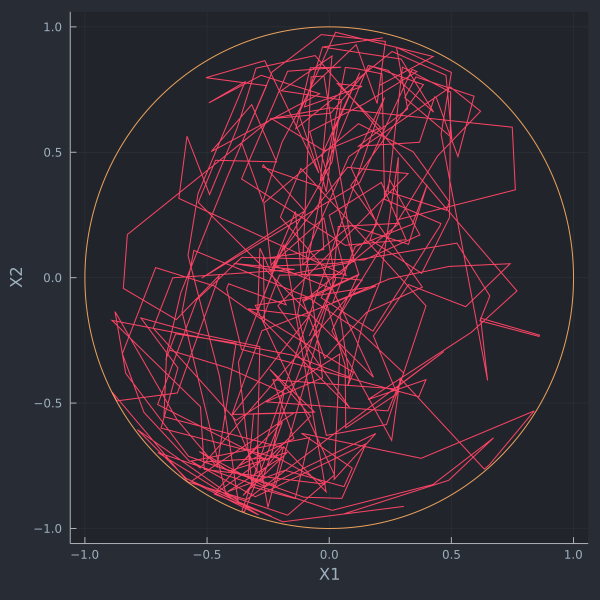

In [198]:
p1 = plot(x[:,1],x[:,2],size=(600,600),xlabel = "X1",ylabel="X2",label="")
theta = collect(0:0.001:2*pi)
r = 1
plot!(r*cos.(theta),r*sin.(theta),label="")

In [9]:
# Simulate 100,000 observations from BPS and remove the first 50,000 as burn-ins
@time BPS_Sample = BPS(100000, x0, u0, δ, refresh_rate);
BPS_Sample = BPS_Sample[50001:end,:];

  0.340346 seconds (5.16 M allocations: 305.907 MiB, 13.32% gc time)


In [10]:
True_Sample = zeros(50000,2)
n = 1
while n <= 50000
    cand = rand(MultivariateNormal(μ,Σ))
    if norm(cand) < 1
        True_Sample[n,:] = cand
        n += 1
    end
end

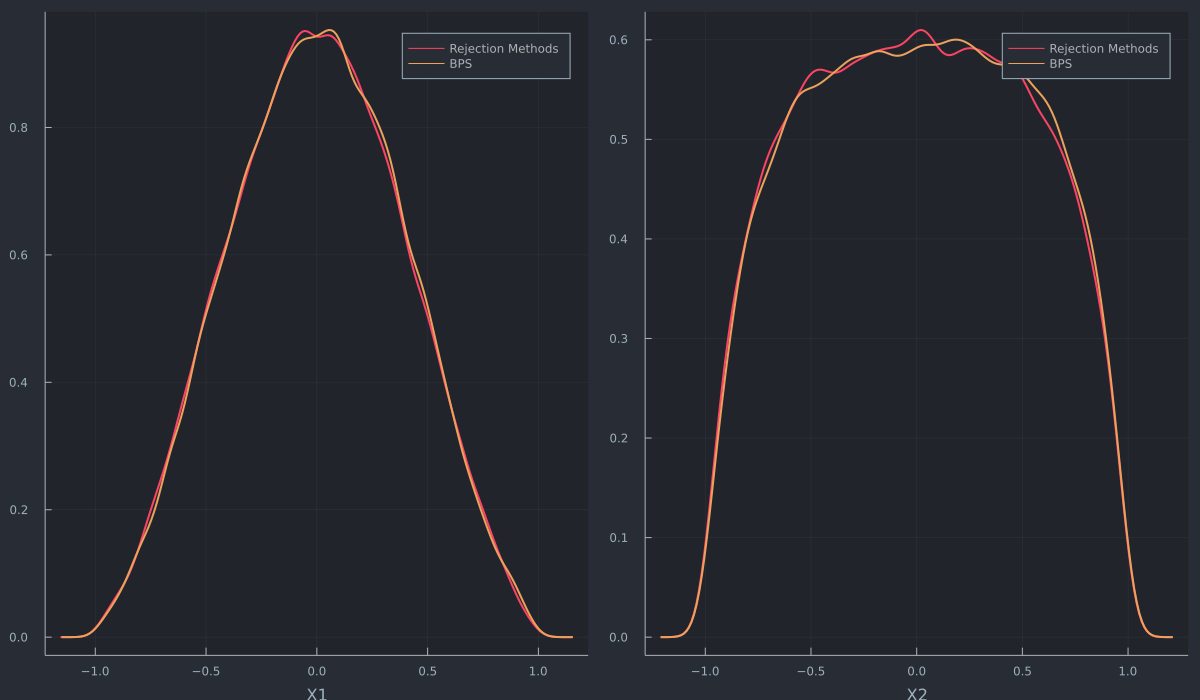

In [197]:
p1 = density(True_Sample[:,1],label="Rejection Methods",linewidth=2,xlabel="X1")
density!(BPS_Sample[:,1],label="BPS",linewidth=2)
p2 = density(True_Sample[:,2],label="Rejection Methods",linewidth=2,xlabel="X2")
density!(BPS_Sample[:,2],label="BPS",linewidth=2)
plot(p1,p2,layout = (1,2),size=(1200,700))

# BPS-SMC-ABC

In this section, we tried to employ the Bouncy Particle Sampler within SMC-ABC methods.  In SMC-ABC, we target 
$$\pi_{n}(\xi) \propto p(\xi) l(x|\xi) P_{\epsilon_n}(x|y^{*}) = p(\xi) l(x|\xi) \mathbb{I} \left(d(x,y) < \epsilon_n\right)$$
at the $n$-th SMC step. 

In [1]:
using Distributions, Plots, StatsPlots, LinearAlgebra, Random
using ForwardDiff: gradient
using LaTeXStrings
theme(:juno)

In [200]:
# function used to transform standard Normal to g-and-k
f(u) = 3.0 + 1.0*(1+0.8*(1-exp(-2.0*u[2]))/(1+exp(-2.0*u[2])))*((1+u[2]^2)^u[1])*u[2];

In [203]:
Random.seed!(12358)
zstar = rand(Normal(0,1))
ystar = f([0.5,zstar])

7.00029493785379

In [204]:
dist(u) = (f(u) - ystar)^2

dist (generic function with 1 method)

## Some Explorations of the shape of the bounded region for different choice of $\epsilon$

Define the prior density of $u = (k,z)$. In this example, we assign a Uniform distribution between $0$ and $10$ to the prior of $k$ and $\mathcal{N}(0,1)$ to the prior of $z$

In [131]:
function logpi(u)
    if C(u) > 0
        logpdf_k = logpdf(Uniform(0,10),u[1])
        logpdf_z = logpdf(Normal(0,1),u[2])
        return logpdf_k + logpdf_z
    else
        return -Inf
    end
end
gradu(u) = gradient(x->logpdf(Uniform(0,10),x[1])+logpdf(Normal(0,1),x[2]),u)
α_pu(x,u,δ) = min(0,logpi(x.+δ*u)-logpi(x))

α_pu (generic function with 1 method)

In this case, we would have two types of reflections:

1. **Boundary Reflection**: This is performed when the first proposal of BPS lies outside the boundary defined by $\epsilon$ and support of the priors. When such thing happens, we do the reflection to try to make the proposal back into the constrained domain we are considering
2. **Energy Reflection**: This is performed when the first proposal of BPS lies within the constrained domain we are considering, but such a move encounters a high energy barrier. In this case, we do the reflection with respect to the log-prior evaluated at the proposed point

In [132]:
function BoundaryReflection(x0,u0,x1,u1,δ)
    if any([x1[1]<0,x1[1]>10])
        u2   = reflect(u1,[sign(10-x1[1]),0])
        x2   = x1 .+ δ*u2
        α_dr = min(0,logpi(x2)-logpi(x0))
        if log(rand(Uniform(0,1))) < α_dr
            return (x2,u2)
        else
            return (x0,-u0)
        end
    elseif C(x1) <= 0.0
        u2 = reflect(u1,gradient(C,x1))
        x2 = x1 .+ δ*u2
        α_dr = min(0,logpi(x2)-logpi(x0))
        if log(rand(Uniform(0,1))) < α_dr
            return (x2,u2)
        else
            return (x0,-u0)
        end
    end
end

BoundaryReflection (generic function with 1 method)

In [133]:
function EnergyReflection(x0,u0,x1,u1,δ)
    u2 = reflect(u1,gradu(x1))
    x2 = x1 .+ δ*u2
    α_dr = min(0,log(1-exp(α_pu(x2,-u2,δ)))-log(1-exp(α_pu(x0,u0,δ)))+logpi(x2)-logpi(x0))
    if log(rand(Uniform(0,1))) < α_dr
        return (x2,u2)
    else
        return (x0,-u0)
    end
end

EnergyReflection (generic function with 1 method)

In [134]:
function DirectionRefresh(u0,refresh_rate)
    ind = rand(Bernoulli(refresh_rate))
    if ind == 0
        return u0
    else
        return normalize(rand(Normal(0,1),2))
    end
end

function reflect(u,v)
    v = normalize(v)
    return u - 2 * (transpose(u)*v)*v
end

α_pu(x,u,δ) = min(0,logpi(x.+δ*u)-logpi(x))

α_pu (generic function with 1 method)

In [135]:
function BPS(N,x0,u0,δ,refresh_rate)
    X       = zeros(N,2)
    X[1,:]  = x0
    acc = 0
    for n = 2:N
        x1 = X[n-1,:] .+ δ*u0
        u1 = u0
        if any([x1[1]<0,x1[1]>10,C(x1)<=0])
            xhat,uhat = BoundaryReflection(X[n-1,:],u0,x1,u1,δ)
        else
            α = α_pu(X[n-1,:],u0,δ)
            if log(rand(Uniform(0,1))) < α
                xhat = x1
                uhat = u1
            else
                xhat,uhat = EnergyReflection(X[n-1,:],u0,x1,u1,δ)
            end
        end
        u0 = DirectionRefresh(uhat,refresh_rate)
        X[n,:] = xhat
        if norm(X[n-1,:] .- X[n,:]) > 1e-10
            acc += 1
        end 
    end
    return (X,acc/N)
end

BPS (generic function with 1 method)

Let's try a Random-walk Metropolis-Hastings algorithm targeting the prior in the constrained domain.

In [136]:
function RWMH(N,x0,stepsize)
    X = zeros(N,2)
    X[1,:] = x0
    acc = 0
    for n = 2:N
        xcand = X[n-1,:] .+ stepsize*rand(Normal(0,1),2)
        α = min(0,logpi(xcand)-logpi(X[n-1,:]))
        if log(rand(Uniform(0,1))) < α
            X[n,:] = xcand
            acc += 1
        else
            X[n,:] = X[n-1,:]
        end
    end
    return X,acc/N
end

RWMH (generic function with 1 method)

In [175]:
function C(x)
    return 0.01 - dist(x)
end
x0 = [rand(Uniform(0,10)),rand(Normal(0,1))]
while C(x0) <= 0
    x0 = [rand(Uniform(0,10)),rand(Normal(0,1))]
end
u0 = normalize(rand(Normal(0,1),2))
X_BPS,α_BPS = BPS(5000,x0 ,u0, 0.05, 0.5);
X_MH,α_NH   = RWMH(5000,x0,0.05);

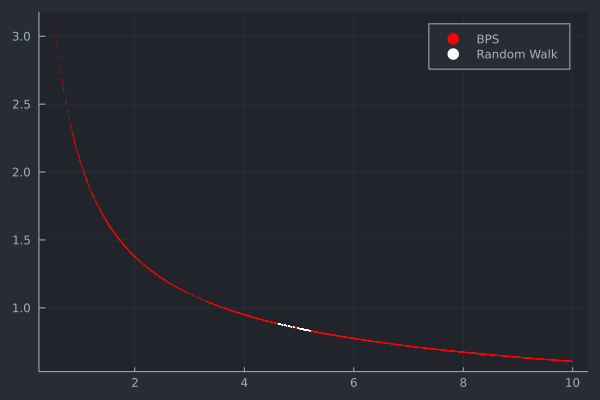

In [176]:
scatter(X_BPS[:,1],X_BPS[:,2],color=:red,markersize=0.1,markerstrokewidth=0,label="BPS")
scatter!(X_MH[:,1],X_MH[:,2],color=:white,markersize=0.1,markerstrokewidth=0,label="Random Walk")

In [177]:
α_NH,α_BPS

(0.0096, 0.8436)